# Exercise Sheet No. 4

---

> Machine Learning for Natural Sciences, Summer 2022, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 16.05.2022, 8am
>
> Tutor: Chen Zhou chen.zhou@kit.edu
>
> Please ask questions in the forum and only contact the tutor for issues regarding the grading

---

**Topic**: 
This exercise sheet will focus on the math basics for ML. You will implement another simple ML algorithm, **linear regression** (LR), instead of decision tree to work on the same task you have already seen in exercise 02. Gradient decent, mean square error loss function, and mean absolute error function are covered in this exercise. And you will learn to use ridge regression to control overfitting.

We will use [seaborn](https://seaborn.pydata.org/index.html) as a more abstract plotting interface in this exercise. You can install it into your current aimat conda environment by executing the following command lines:

`conda activate aimat`

`conda install seaborn`

# Linear Regression
In assignment 2, we have seen the use of decision tree for iris species classification. Now, let's try to solve the same problem with another simple machine learning technique: linear regression (LR).   

Linear regression uses a linear combination of features to predict a target. In our case we can use a linear combination of the four flower descriptors to predict the species.

In this assignment, you will learn to implement the Loss function and Gradient Decent for optimization. Then, we will see that even small model like LR can overfit, and how regularization (ridge regression) can help against this problem.

In [312]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
from functools import wraps
warnings.filterwarnings('ignore')

## Preprocessing
Let's start with preprocessing the dataset, as already learned from assignment 2.

In [313]:
def log_name(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\n{func.__name__}:")
        return result
    return wrapper

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tshape: {result.shape}")
        return result
    return wrapper

def log_columns(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tcolumns: {result.columns.values}")
        return result
    return wrapper

@log_columns
@log_shape
@log_name
def load(df, path):
    """Loads the dataset from path."""
    df = pd.read_csv(path)
    return df

@log_columns
@log_shape
@log_name
def convert_to_categorical(df, col_name: str):
    df[col_name] = df[col_name].astype('category')
    return df

@log_columns
@log_shape
@log_name
def add_class_labels(df):
    df['class'] = df['species'].cat.codes
    return df

In [314]:
df = pd.DataFrame()
df = (
    df.pipe(load, 'iris.csv')
      .pipe(convert_to_categorical, 'species')
      .pipe(add_class_labels)
)


load:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

convert_to_categorical:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

add_class_labels:
	shape: (150, 6)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species'
 'class']


## Plot the data
It is always a good practice to have some inspection on the dataset. This provides us with information about the data such as its structure, range, outliers etc., which may help on the design of ML algorithm. There are numerous ways to visualize data, and introduced here is the one called "Pairplot", which displays pairwise relationships in a dataset. Pairplot can be implemented easily with the [seaborn](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) library. Here we used it to show the pairwise relationships among iris features.

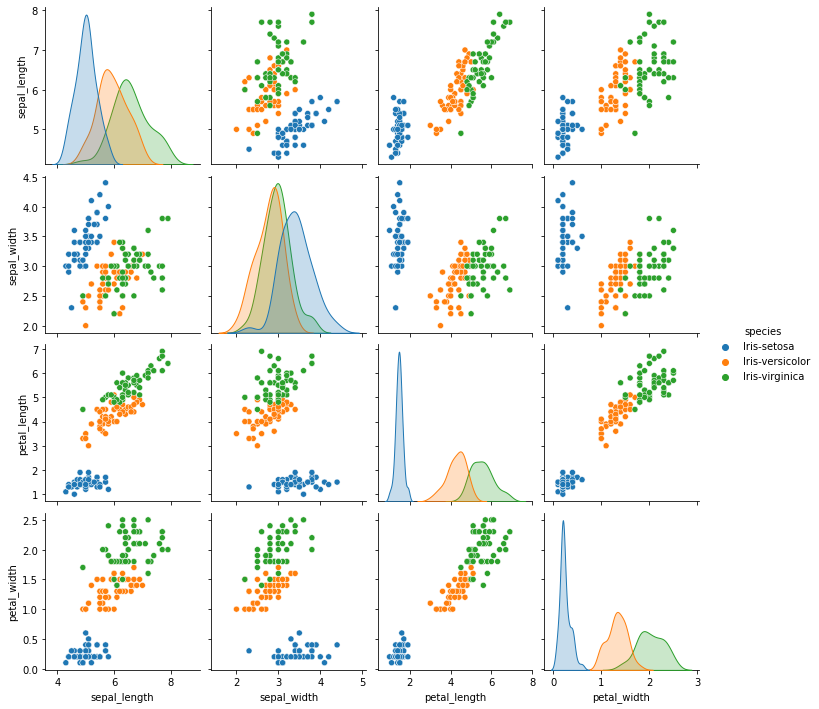

In [315]:
sns.pairplot(df.loc[:,:'species'], hue= 'species')
plt.show()

**Question**: out of these combinations of features, which pair has the strongest linear correlation relationship?

**1.** sepal_length and petal_width    
**2.** sepal_width and petal_length    
**3.** petal_length and petal_width    
**4.** sepal_width and petal_length    
**5.** sepal_length and sepal_width

(To learn more about the linear correlation, please refer to [here](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient))

Assign the number of your choice to the variable `A`:

In [316]:
A = 3

In [317]:
assert type(A) == int # Please make sure your input is a number.

# Hidden test below
# 1 point: select the correct choice.

## Generate training/validation set
Now, for our machine learning task, let's extract feature matrix `X` and label matrix `Y` from the dataframe `df`. Please implement the `split_X_Y` function that returns feature `X` as a $150 \times 4$ numpy array, as well as label `Y` as a $150 \times 1$ numpy array. `X` should contain values from column "sepal_length", "sepal_width", "petal_length" and "petal_width". `Y` should be the value of column "class". You may use methods such as `.reshape()` etc., and attributes like `.values`.

In [318]:
def split_X_Y(df):
    """split the dataframe into feature matrix X and label matrix Y"""
    X = None # please update this in your solution
    Y = None # please update this in your solution
    # YOUR CODE HERE
    X = df.loc[:, ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
    Y = df.loc[:, ['class']].values
    return X, Y

In [319]:
# feature/target split
X, Y = split_X_Y(df)
assert X.shape == (150, 4)
assert Y.shape == (150, 1)

# Hidden test below
# 2 points: values in X and Y are checked

We have learned that the linear model tries to fit the function:
\begin{align}
y = \omega^T x + \omega_0 = \sum^n_{i=1} \omega_i x_i + \omega_0
\end{align}
Where $\omega$ is the weight matrix and $\omega_0$ is the bias term. Let $x_0 = 1$, this function can be rewritten into:
\begin{align}
y =  \sum^n_{i=1} \omega_i x_i + \omega_0 x_0 = \sum^n_{i=0} \omega_i x_i = X \Omega^T
\end{align}
$\Omega$ can be initialized randomly, and optimized later through training. In our case $\Omega$ has five elements - the first one for the bias and rest four for the weights.

**Please note that $\Omega$ is written as a row vector in many text books for display convenience and is actually a column vector during implementation. That's why we have $\Omega^T$ in the equation to denote the convertion. Here we use `numpy.T` to make our code and equation consistent.**

In [320]:
# random initialization for weights and bias
np.random.seed(0)
omega = np.random.randn(1,5).T
omega

array([[1.76405235],
       [0.40015721],
       [0.97873798],
       [2.2408932 ],
       [1.86755799]])

Now let's contract $x_0 = 1$ to our feature matrix `X` to obtain the input matrix for LR model. Please do that by stacking a new column to `X` as the first colunm with all values equal to $1$. This may be easily implemented with the numpy method `.hstack()` . You may find more details [here](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html).

In [321]:
# Update feature matrix X with x0 = 1
X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))

In [322]:
assert X.shape == (150, 5) # now the shape of X should change from (150, 4) to (150, 5)

# 1 point: values in X are checked
assert (X[:, 0] == 1).all()

In case you are interested, there's a "closed-form solution" that estimates the best parameter set $\Omega^*$ by solving the equation:
\begin{align}
\Omega^* = (X^TX)^{-1}X^Ty
\end{align}
Watch this [video](https://www.coursera.org/lecture/ml-regression/approach-1-closed-form-solution-G9oBu) from coursera for detailed explanation.

## Gradient Decent
For more complex tasks, a closed form solution often doesn't exist and hence we will introduce another approach here, aka Gradient Decent (GD) algorithm, to solve the linear regression. Gradient Decent works by updating the weight vector incrementally after each epoch. Read more [here](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

Firstly, let's do a train-valid split for our dataset, as we have already seen in Assignment 2. The `x_train` and `y_train` will be our training set, and `x_val`, `y_val` will be our validation set. Just to refresh your memory, training set is used for training to improve our model performance, while validation set tests the model with unseen data. Testing our model with validation set is crucial especially when we want to know the generalization ability of the model. You will see more details later in the Overfitting & Ridge regression section.

Here we randomly shuffle the dataset and take $120$ $(80\%)$ data points as training set. The rest $30$ $(20\%)$ are used as validation set. There's also a useful method `sklearn.model_selection.train_test_split()` from scikit-learn for the same purpose. You can find its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [323]:
idx = list(range(0, 150))
random.shuffle(idx)
x_train = X[idx[:120]]
y_train = Y[idx[:120]]
x_val = X[idx[120:]]
y_val = Y[idx[120:]]

### Cost function
The mean squared error (mse) is a common loss function that measures the average squared difference between predict and real values. Here, it is defined as:
\begin{align}
MSE = \frac{1}{2n}\sum^n_{i=1}(\text{y_pred}_i - \text{y_real}_i)^2
\end{align}
The $\frac{1}{2}$ in equation is just for convenience when computing the gradient (see next step). Recall that $y = X \Omega^T$, so we have:
\begin{align}
MSE = \frac{1}{2n}\sum^n_{i=1}(x_i \Omega^T - \text{y_real}_i)^2
\end{align}
Please implement the `mean_square_error()` that returns MSE. Methods/attribute you may need are `numpy.sum()` and `numpy.dot()`. Although we use a $\sum$ in the notation you can use your knowledge from exercise 3 to compute the following using only numpy vectors and matrices.

In [324]:
def mean_square_error(x, y, omega):
    """
    return the mean suqared error.
    
    Args:
        x (numpy.ndarray): numpy array of features.
        y (numpy.ndarray): numpy array of corresponding classes.
        omega (numpy.ndarray): weight vector.
        
    Returns:
        mse (numpy.float64): mean squared error.
    """
    mse = None # please update this in your solution
    # YOUR CODE HERE
    pred = x @ omega
    n = x.shape[0]

    mseSum = np.sum((pred - y)**2)
    mse = 1/(2*n) * mseSum
    
    return mse

In [325]:
# 1 point: a simple test to check if your mse function works
a = np.array([[1.0, 2.0], [2.0, 2.0]])
b = np.array([[1.0], [2.0]])
w = np.array([[1.0, 1.0]]).T
result = mean_square_error(a, b, w)
assert result - 2.0 <= 0.01
assert str(type(result)) == "<class 'numpy.float64'>"

# Hidden test below
# 1 point: further tests to check the output of the mse function

After each epoch $t$, the Gradient Decent algorithm updates the weight vector in the direction of the negative gradient in order to reduce the cost function. The gradient is simply the partial derivative of mean squared error to the weight.

You can deduce the derivative yourself for practice. Just run the following cell to render the answer:

In [326]:
from IPython.display import display, Markdown

display(Markdown("\\begin{align}"
                 "\\frac{\\partial MSE}{\\partial \\Omega} &= "
                 "\\frac{1}{n} \\sum^n_{i=0}(x_i \\Omega^T - \\text{y_real}_i) x_i \\\\"
                 "\\Omega(t+1) &= \\Omega(t) - \\alpha \\frac{\\partial MSE}{\\partial \\Omega(t)}"
                 "= \\Omega(t) - \\frac{\\alpha}{n} \\sum^n_{i=0}(x_i \\Omega^T - \\text{y_real}_i) x_i"
                 "\\end{align}"))

\begin{align}\frac{\partial MSE}{\partial \Omega} &= \frac{1}{n} \sum^n_{i=0}(x_i \Omega^T - \text{y_real}_i) x_i \\\Omega(t+1) &= \Omega(t) - \alpha \frac{\partial MSE}{\partial \Omega(t)}= \Omega(t) - \frac{\alpha}{n} \sum^n_{i=0}(x_i \Omega^T - \text{y_real}_i) x_i\end{align}

The $\alpha$ is the learning rate that controls the step size for the update after each iteration.

Please implement the `weight_update_function()` that returns updated $\Omega$. Methods/attribute you may need are `numpy.dot()` and `numpy.reshape()`.

In [327]:
def weight_update_function(x, y, omega, alpha):
    """
    return updated set of weights
    
    Args:
        x (numpy.ndarray): numpy array of features.
        y (numpy.ndarray): numpy array of corresponding classes.
        omega (numpy.ndarray): weight vector.
        alpha (float): learning rate.
        
    Returns:
        omega_updated (numpy.ndarray): the updated weight vector.
    """
    omega_updated = None # please update this in your solution
    # YOUR CODE HERE
    pred = x @ omega
    n = x.shape[0]
    mse = pred - y
    
    omega_updated = omega - (alpha * (1/n)*np.sum(mse * x, axis=0)).reshape(omega.shape)
    
    return omega_updated

In [328]:
# 1 points: check the output value and shape of your weight_update_function
result = weight_update_function(a, b, w, 0.001)
assert abs(np.mean(result) - 0.996) <= 0.01
assert result.shape == w.shape

# Hidden test below
# 1 point: further tests to check the output of the weight_update_function function

### Training & plot
To monitor the training process, here we use mean absolute error (mae):
\begin{align}
MAE = \frac{1}{n}\sum^n_{i=1} |\text{y_pred}_i - \text{y_real}_i|
\end{align}
Please implement the `mean_absolute_error()` that returns MAE. Methods/attribute you may need are `numpy.sum()`, `numpy.dot()` and `numpy.abs()`.

In [329]:
def mean_absolute_error(x, y, omega):
    """
    return the mean absolute error
    
    Args:
        x (numpy.ndarray): numpy array of features.
        y (numpy.ndarray): numpy array of corresponding classes.
        omega (numpy.ndarray): weight vector.
        
    Returns:
        mse (numpy.float64): mean absolute error.
    """
    mae = None # please update this in your solution
    # YOUR CODE HERE
    
    n = x.shape[0]
    mae = 1/n*np.sum(np.abs(x @ omega - y))
    return mae

In [330]:
# 1 points: check the output value and shape of your mean_absolute_error function
result = mean_absolute_error(a, b, w)
assert np.round(result)  == 2.0
assert str(type(result)) == "<class 'numpy.float64'>"

# Hidden test below
# 1 point: further tests to check the output of the mean_absolute_error function

For the last step before training the model, let's set up the learning rate and number of iterations. We use `J_train` and `J_val` to record mean absolute errors for each epoch of the training and validation processes.

In [331]:
epochs = 15000 # number of updates to the weight
alpha = 0.001 # learning rate
J_train = np.zeros(epochs) # MAE of training process
J_val = np.zeros(epochs) # MAE of validation process

Now, let's train our model with the `weight_update_function()` and record mean absolute errors through `mean_absolute_error()` for the training/validation process.

In [332]:
np.random.seed(0)
omega = np.random.randn(1,5).T # initialize weight/bias matrix randomly

# begin training
for i in range(epochs):
    """
    for each epoch, record the mae for training and validation process
    use the weight_update_function to update the omega
    """
    J_val[i] = None # please update this in your solution
    J_train[i] = None # please update this in your solution
    
    # YOUR CODE HERE
    J_train[i] = mean_absolute_error(x_train, y_train, omega)
    J_val[i] = mean_absolute_error(x_val, y_val, omega)   
    omega = weight_update_function(x_train, y_train, omega, alpha)

In [333]:
# 2 point: check the results of the training process 
assert J_train[-1] > 0
assert np.std(J_val[-10:]) <= 1e-3 # the training process should converge

# Hidden tests below
# 1 point: further tests for the training/validation results

Here the `plot_training_curve()` is implemented to visualize the training process.

In [334]:
def plot_training_curve(MAE_train, MAE_val, epochs):
    """Plot the mean absolute error for training/validation process"""
    fig, ax = plt.subplots(figsize=(7.5, 5))
    ax.plot(np.arange(epochs), MAE_train, label='Training')
    ax.plot(np.arange(epochs), MAE_val, label='Validation')
    ax.set_ylim([0,1])
    ax.set_ylabel("Mean Absolute Error")
    ax.set_xlabel("Epochs")
    ax.set_title("Mean Absolute Error vs Epochs")
    ax.legend(loc='upper right')
    plt.show()

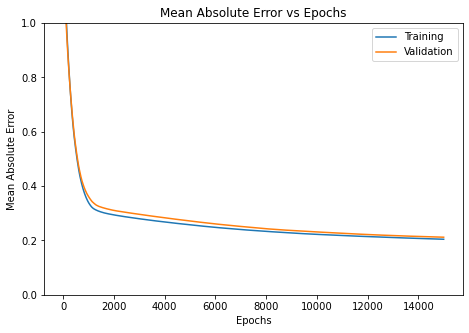

In [335]:
plot_training_curve(J_train, J_val, epochs)

**Question:** You may notice that we have implemented the `mean_square_error()` function but seemed to never use it in the training process. Please think about the reason and write it down here.
Hint: double check the deduce process of the Gradient Decent.

In [336]:
your_answer = (
    "It was just to get a feeling for implementing the mean_square_error, which is very simmilar to the weight_update_function, which we then used instead"
)

In [337]:
# 1 point for the answer
assert type(your_answer) == str
assert len(your_answer) > 1

### Accuracy
Now, with the optimized weight vector, let's implement `prediction()` to get the predicted class labels from our linear model. You may need `numpy.dot()` for the computation, and `numpy.round()` to round up the results into integers (because our class labels are integer 0, 1, 2).

In [338]:
def prediction(x, omega):
    """
    Return predicted labels.
    
    Args:
        x (numpy.ndarray): the feature matrix.
        omega (numpy.ndarray): optimized weight vector
        
    Returns:
        y_pred (numpy.ndarray): predicted labels.
    """
    y_pred = None # please update this in your solution
    # YOUR CODE HERE
    y_pred = np.round(x @ omega)
    return y_pred

In [339]:
# 1 point
Y_pred = prediction(X, omega)
assert Y_pred.shape == Y.shape

With `Y_pred`. Please implement `accuracy()` that calculates the prediction accuracy.

Hint: prediction accuracy is computed by counting the number of predictions that match the real values, and then devide by the number of total instances.

In [340]:
def accuracy(y_pred, y):
    """
    Compute the accuracy of prediction.
    
    Args:
        y_pred (numpy.ndarray): the predicted class labels.
        y (numpy.ndarray): the real class labels.
        
    Returns:
        acc (numpy.float64): calculated accuracy in float.
    """
    acc = None # please update this in your solution
    # YOUR CODE HERE
    acc = np.sum(y == y_pred) / y.shape[0]
    return acc

In [341]:
acc = accuracy(Y_pred, Y)
acc

0.9333333333333333

In [342]:
assert str(type(acc)) == "<class 'numpy.float64'>"

# Hidden test below
# 1 point: test the output value of the accuracy() function

### Visualize predictions vs ground truth
For the last step, let's visualize our predictions v.s. the real labels.

In [343]:
def plot_predict_vs_real(Y_pred, Y):
    """Plot the predictions vs ground truch"""
    fig, ax = plt.subplots(figsize=(7.5, 5))
    ax.scatter(np.arange(1, 151, 1), Y_pred, label='Predictions')
    ax.plot(np.arange(1, 151, 1), Y, label='Ground Truch', color='red')
    ax.legend(loc="upper left")
    plt.yticks(np.arange(0, 3, 1))
    plt.show()

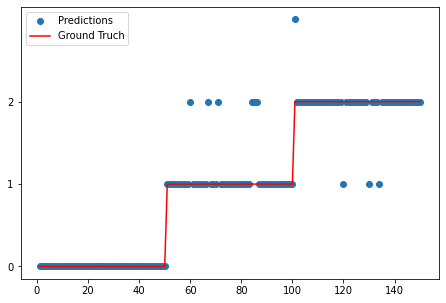

In [344]:
plot_predict_vs_real(Y_pred, Y)

Please feel free to play around with the model and training process. You may adjust the learning rate and number of epochs to see how the trainig curve changes (do not forget to re-initialize the weight vector). You may also try different train-validation split ratio to see the effect.

You may notice that the training results differ a lot with different hyperparameters (learning rate, omega initialization, etc.). This is one limitation of such simple ML model. Later in this semester, you will see and implement more sophisticated ML algorithms that can make more stable and accurate predictions.

## Overfitting & Ridge regression

When finishing this assignment, you may (and may not, depending on the training set setup) sometimes observe the gap between the training curve and validation curve (validation error higher than training error) that cannot be diminished by increasing the number of epochs. This phenomenon is known as "overfitting". It happens when the model gets too complex so that it fits the training set perfectly, but loses the generalization ability towards unseen data from validation/test set.

Ridge regression, also known as L2 regularization, is a useful technique to restrict our model from getting too complicated and reduce the effect of overfitting. It works by simply adding a penalty term to the cost function. In our case, the penalty term is $||\Omega||^2$. It prefers lower absolute values of weights thus reduce the model complexity. For more information, please refer to [here](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization).

By introducting the penalty term, our cost function becomes:
\begin{align}
MSE = \frac{1}{2}(\frac{1}{n}\sum^n_{i=1}(\text{y_pred}_i - \text{y_real}_i)^2 + \lambda ||\Omega||^2)
\end{align}
$\lambda$ is the coefficient to adjust the regularization effect.

While the mean absolute error calculation stays the same, the weight update function becomes:
\begin{align}
\Omega = \Omega - \alpha \frac{\partial MSE}{\partial \Omega} = \Omega - \alpha(\frac{1}{n} \sum^n_{i=0}(x_i \Omega^T - \text{y_real}_i) x_i + \lambda ||\Omega||) 
\end{align}
Now, please implement the new cost function `mean_square_error_ridge()` and `weight_update_function_ridge()` with the penalty term. You may use `mean_square_error()` and `weight_update_function()` that are implemented earlier as references.

In [345]:
def mean_square_error_ridge(x, y, omega, lam):
    """
    return the mean suqared error.
    
    Args:
        x (numpy.ndarray): numpy array of features.
        y (numpy.ndarray): numpy array of corresponding classes.
        omega (numpy.ndarray): weight vector.
        lam (float): ridge regression coefficient.
        
    Returns:
        mse (numpy.float64): mean squared error.
    """
    mse = None # please update this in your solution
    # YOUR CODE HERE
    n = x.shape[0]
    y_pred = x @ omega
    mse = mean_square_error(x, y, omega) + 1/2 * lam * np.linalg.norm(omega)**2
    return mse

In [346]:
# 1 point: check the output value
a = np.array([[1.0, 2.0], [2.0, 2.0]])
b = np.array([[1.0], [2.0]])
w = np.array([[1.0, 1.0]]).T
assert np.round(mean_square_error_ridge(a, b, w, 0.1), 1) == 2.1

In [347]:
def weight_update_function_ridge(x, y, omega, alpha, lam):
    """
    return updated set of weights
    
    Args:
        x (numpy.ndarray): numpy array of features.
        y (numpy.ndarray): numpy array of corresponding classes.
        omega (numpy.ndarray): weight vector.
        alpha (float): learning rate.
        lam (float): ridge regression coefficient.
        
    Returns:
        omega_updated (numpy.ndarray): the updated weight vector.
    """
    omega_updated = None # please update this in your solution
    # YOUR CODE HERE
    pred = x @ omega
    n = x.shape[0]
    mse = pred - y
    
    omega_updated = weight_update_function(x, y, omega, alpha) - alpha * lam * np.linalg.norm(omega)
    return omega_updated

print(weight_update_function_ridge(a, b, w, 0.001, 0.1))

[[0.99685858]
 [0.99585858]]


In [348]:
# 1 point: check the output value
assert abs(np.mean(weight_update_function_ridge(a, b, w, 0.001, 0.1)) - 0.99) <= 0.01
assert w.shape == weight_update_function_ridge(a, b, w, 0.001, 0.1).shape

Now, let's look at a very unbalanced training set. In this example, only 25 instances are used as training set ($17\%$), and the number of class 0 is significantly higher than both class 1 and 2.

In [349]:
import pickle
with open('iris_overfit', 'rb') as f:
    x_train, x_val, y_train, y_val = pickle.load(f)

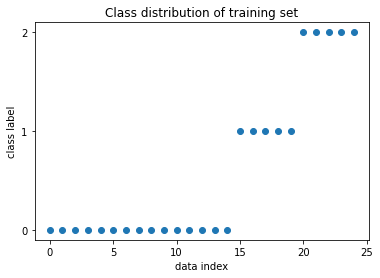

In [350]:
fig, ax = plt.subplots()
ax.scatter(np.arange(0, len(y_train), 1), y_train)
plt.yticks(np.arange(0, 3, 1))
ax.set_xlabel("data index")
ax.set_ylabel("class label")
ax.set_title("Class distribution of training set")
plt.show()

For the training, let's do the normal linear regression and ridge regression side by side, with `J_train`, `J_val` recording linear regression training/validation MAE, and `J_train_ridge`, `J_val_ridge` recording ridge regression MAE. Please implement them in the same `for` loop.

In [351]:
np.random.seed(0)
omega = np.random.randn(5,1)
epochs = 3000 # number of updates to the weight
alpha = 0.0005 # learning rate
lam = 0.5 # coefficient of L2 penalty
J_train = np.zeros(epochs) # record MAE of training process (without penalty)
J_val = np.zeros(epochs) # record MAE of validation process (without penalty)
J_train_ridge = np.zeros(epochs) # record MAE of training process (with penalty)
J_val_ridge = np.zeros(epochs) # record MAE of validation process (with penalty)

In [352]:
omega_norm = np.copy(omega) # weight vector for training without penalty
omega_ridge = np.copy(omega) # weight vector for ridge regression

for i in range(epochs):
    # for each epoch, record the mae for training and validation process without using ridge regression
    # use the weight_update_function to update the omega_norm
    J_val[i] = None # please update this in your solution
    J_train[i] = None # please update this in your solution
    
    # YOUR CODE HERE
    J_train[i] = mean_absolute_error(x_train, y_train, omega_norm)
    J_val[i] = mean_absolute_error(x_val, y_val, omega_norm)
    
    # Now, let's try to optimize omega using ridge regression
    # use the weight_update_function_ridge to update the omega_ridge
    J_val_ridge[i] = None # please update this in your solution
    J_train_ridge[i] = None # please update this in your solution
    
    # YOUR CODE HERE
    J_train_ridge[i] = mean_absolute_error(x_train, y_train, omega_ridge)
    J_val_ridge[i] = mean_absolute_error(x_val, y_val, omega_ridge)
    
    omega_norm = weight_update_function(x_train, y_train, omega_norm, alpha)
    omega_ridge = weight_update_function_ridge(x_train, y_train, omega_ridge, alpha, lam)

In [353]:
# 2 point: check the results of the training process
assert J_train_ridge[-1] > 0
assert np.std(J_val_ridge[-10:]) <= 1e-3 # the model should converge after training

# Hidden test below
# 1 point: further tests of the training results

Now we plot the training curves again, but this time on a log-log scale to better see the differences:

In [354]:
def plot_training_curve_ridge(MAE_train, MAE_val, MAE_train_ridge, MAE_val_ridge, epochs):
    """Plot the mean absolute error for training/validation process"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].loglog(np.arange(epochs), MAE_train, label='Training')
    ax[0].loglog(np.arange(epochs), MAE_val, label='Validation')
    #ax.set_ylim([0,1])
    ax[0].set_ylabel("Mean Absolute Error")
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Without L2 Regularization")
    ax[0].legend(loc='upper right')
    
    ax[1].loglog(np.arange(epochs), MAE_train_ridge, label='Training')
    ax[1].loglog(np.arange(epochs), MAE_val_ridge, label='Validation')
    #ax.set_ylim([0,1])
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].set_xlabel("Epochs")
    ax[1].set_title("With L2 Regularization")
    ax[1].legend(loc='upper right')
    plt.show()

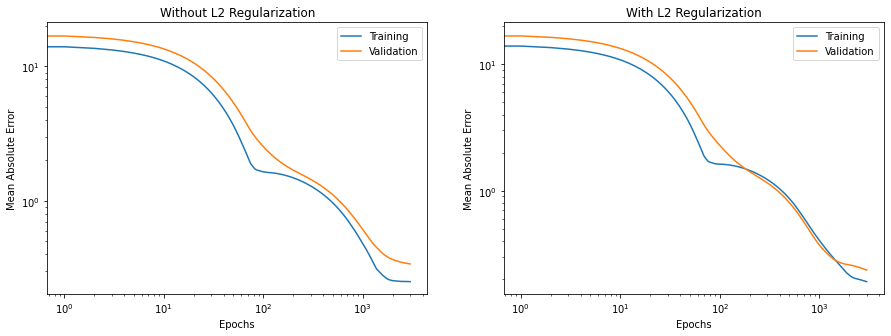

In [355]:
plot_training_curve_ridge(J_train, J_val, J_train_ridge, J_val_ridge, epochs)

In [356]:
Y_pred = prediction(X, omega_norm)
Y_pred_ridge = prediction(X, omega_ridge)
acc = accuracy(Y_pred, Y)
acc_ridge = accuracy(Y_pred_ridge, Y)
print(acc)
print(acc_ridge)

0.8066666666666666
0.8933333333333333


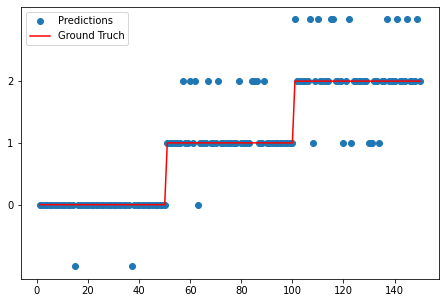

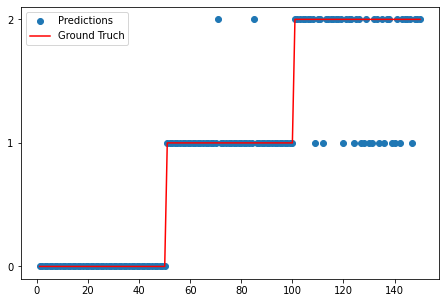

In [357]:
plot_predict_vs_real(Y_pred, Y)
plot_predict_vs_real(Y_pred_ridge, Y)

**Yes or No question:** from the plots/accuracy calculations, do you think the ridge regression improved the learning performance?

In [358]:
Answer = "Yes"

## Scipy Optimize

Rather than handcraft the Gradient Decent algorithm, there are libraries that can do the optimization task automatically. The `minimize()` function provided by SciPy library is a good example. It takes as input the name of the function that needs to be minimized, the initial point where the search starts and (optionally) the name of a specific search algorithm. It returns a `OptimizeResult` object that contains details of the optimization result. Below is an example of using `minimize()` function to optimize our linear model.

In [359]:
from scipy.optimize import minimize

np.random.seed(0)
omega = np.random.randn(1,5)

def mean_square_error(omega):
    return (1/(2*len(X)) * np.sum((np.dot(X, omega.reshape(1,5).T) - Y) ** 2 ))


res = minimize(mean_square_error, omega, method='L-BFGS-B')
print(res)
omega_op = np.array(res.x).reshape(5,1)

      fun: 0.023192544205749906
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.52883606e-06, -5.74717357e-05, -2.82062568e-05, -4.07007761e-05,
       -1.35561700e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 102
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([ 0.19207421, -0.10974337, -0.04423664,  0.22700255,  0.60989029])


In [360]:
Y_pred = prediction(X, omega_op)
acc = accuracy(Y_pred, Y)
acc

0.9733333333333334

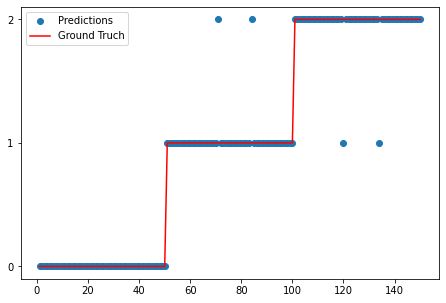

In [361]:
plot_predict_vs_real(Y_pred, Y)

You can find a good tutorial of SciPy optimization [here](https://machinelearningmastery.com/function-optimization-with-scipy/).  

If you have more questions, please refer to the SciPy [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html).

For the introduction of the "L-BFGS-B" search algorithm using here, please read [this](http://sepwww.stanford.edu/data/media/public/docs/sep117/antoine1/paper_html/node6.html).

***Please do this in a separate notebook that is not submitted!***

Thank you very much for participating the exercise! I hope you find it helpful to understand math basics in machine learning!